In [109]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

## Listings

In [39]:
def listing_cleanup(path):
    """
    This function takes an airbnb listing and returns the columns that will be needed for merging later
    """
    listings = pd.read_csv(path)
    listings.rename(columns = {'neighbourhood_group_cleansed':'area'},inplace = True)
    
    cols_to_use = []
    for x in pd.read_json('/Users/amishdalal/DSI-NYC-2/projects/projects-capstone/AirBnB/abnb_cols_to_use.json')[0]:
        cols_to_use.append(x)
    cols_to_use.append('neighbourhood_cleansed')
    listings = listings.loc[:,cols_to_use]
    
    listings.rename(columns = {'neighbourhood':'neighborhood'},inplace = True)
    if listings['price'].dtype != 'int64':
        #converting price to int
        listings['price'] = listings['price'].apply(lambda x: x.replace('$','').replace(',','').replace('.00','')).astype(int)
    else:
        pass
    #only selecting non null bedrooms
    listings = listings[listings['bedrooms'].notnull()]
    #converting bedrooms to int
    listings['bedrooms'] = listings['bedrooms'].astype(int)
    #only selecting real beds
    listings = listings[listings['bed_type']=='Real Bed']
    
    #creating a groupby to get each listings avg price
    listings = listings.groupby(['id','neighborhood','zipcode','bedrooms','bathrooms','room_type',\
                          'number_of_reviews','review_scores_rating'])['price'].mean().to_frame()
    listings.reset_index(inplace = True)
    #ensuring that all neighborhoods are 
    nhood_area = pd.read_csv('/Users/amishdalal/DSI-NYC-2/projects/projects-capstone/AirBnB/neighbourhoods.csv')
    
    listings = pd.merge(listings,nhood_area,on=['neighborhood'])
    listings.rename(columns = {'id':'listing_id'},inplace = True)
    
    return listings


def calendars(path,listings_df,occ_lower,occ_upper,review_limit):
    """
    This function takes the calendars that were aggregated from each csv file and merges with listings dataframe.
    Also filters out low/high occupancies, takes a minimum review number, filters out 5 or more bedrooms and shared rooms
    """
    cal_df = pd.read_csv(path,index_col=0)
    cal_df.rename(columns = {'neighbourhood':'neighborhood'},inplace = True)
    
    #merging with listings df
    cal_df = pd.merge(cal_df,listings_df)

    print 'Original DataFrame shape is:',cal_df.shape
    #dropping duplicates
    cal_df.drop_duplicates(inplace = True)
    print 'DataFrame after dropping duplicates is:',cal_df.shape
    
    #dropping any room types that are null, shared room or any bedrooms greater than 5 (only using 4 or less)
    
    cal_df1 = cal_df[(cal_df['room_type'].notnull()) & (cal_df['room_type']!='Shared room') & cal_df['bedrooms'] < 5]
    
    #because there are some that are inactive listings, that could be whole calendar is blocked (high yearly occupancy)
    #or low occupancy (very high price)
    
    #setting occupancy limits
    cal_df1 = cal_df[(cal_df['occ_yr%']<=occ_upper) & (cal_df['occ_yr%']>=occ_lower)]
    
    #setting min number of reviews to indicate activity
    print 'Min number of reviews in this dataframe is:',cal_df1['number_of_reviews'].min()
    cal_df2 = cal_df1[cal_df1['number_of_reviews']>=review_limit]
    
    return cal_df2
    

    
def one_br_split(df):
    """
    This function takes the calendar dataframe that is cleaned and returns only one bedroom listings
    """
    df = df[(df['bedrooms']==1)].copy()
    df['revpar'] = (df['avg_price'] * df['occ%']/100)
    
    return df

def entire_unit_split(df):
    occ_entire = df[(df['room_type']!='Private room')].copy()
    occ_entire['bedrooms'].value_counts()
    
    competitors = occ_entire.groupby(['zipcode','neighborhood','bedrooms'])['listing_id'].count().to_frame('num_comp')
    competitors.reset_index(inplace = True)

    occ_entire = pd.merge(occ_entire,competitors,on=['zipcode','neighborhood','bedrooms'])
    occ_entire = occ_entire[occ_entire['avg_price']!=0]  
    
    return occ_entire
    
#path = '/Users/amishdalal/DSI-NYC-2/projects/projects-capstone/AirBnB/calendar_2016_agg_df_120716.csv'
# occ16_1br_all = one_br_split(calendars(path,listings_16df,25,80,5))  
# occ16_entire = entire_unit_split(calendars(path,listings_16df,25,80,5)) 

### 2015

In [40]:
listings_15df = listing_cleanup('airbnb_files/listings_122015.csv')
listings_15df.head()

,listing_id,neighborhood,zipcode,bedrooms,bathrooms,room_type,number_of_reviews,review_scores_rating,price,area,sub_area
0,105,Hell's Kitchen,10036,1,1.0,Private room,39,96.0,149,Manhattan,Midtown
1,4989,Hell's Kitchen,10036,1,1.0,Entire home/apt,13,85.0,200,Manhattan,Midtown
2,5178,Hell's Kitchen,10019,1,1.0,Private room,207,87.0,73,Manhattan,Midtown
3,5818,Hell's Kitchen,10019,1,1.0,Private room,43,94.0,195,Manhattan,Midtown
4,5862,Hell's Kitchen,10019,2,2.0,Entire home/apt,30,93.0,475,Manhattan,Midtown


### 2016

In [44]:
listings_16df = listing_cleanup('airbnb_files/listings_102016.csv')
listings_16df.head()

,listing_id,neighborhood,zipcode,bedrooms,bathrooms,room_type,number_of_reviews,review_scores_rating,price,area,sub_area
0,2515,Harlem,10026,1,1.0,Private room,143,92.0,59,Manhattan,Upper Manhattan
1,8225,Harlem,10026,1,1.0,Private room,105,90.0,49,Manhattan,Upper Manhattan
2,9704,Harlem,10027,1,1.5,Private room,37,98.0,55,Manhattan,Upper Manhattan
3,15345,Harlem,10026,1,1.0,Private room,98,93.0,85,Manhattan,Upper Manhattan
4,23481,Harlem,10027,1,1.0,Entire home/apt,69,90.0,140,Manhattan,Upper Manhattan


## Calendars

### 2015

In [63]:
path15 = 'airbnb_files/calendar_2015_agg_df_120616.csv'
occ15 = calendars(path15,listings_15df,0,100,0)
occ15_1br_all = one_br_split(calendars(path15,listings_15df,25,80,5))  
occ15_entire = entire_unit_split(calendars(path15,listings_15df,25,80,5))

Original DataFrame shape is: (156636, 20)
DataFrame after dropping duplicates is: (156636, 20)
Min number of reviews in this dataframe is: 1
Original DataFrame shape is: (156636, 20)
DataFrame after dropping duplicates is: (156636, 20)
Min number of reviews in this dataframe is: 1
Original DataFrame shape is: (156636, 20)
DataFrame after dropping duplicates is: (156636, 20)
Min number of reviews in this dataframe is: 1


In [64]:
print 'Dataframe for calendar for all listings',occ15.shape
print 'Dataframe for 1BR units:',occ15_1br_all.shape
print 'Dataframe for Entire home/apt units:',occ15_entire.shape

Dataframe for calendar for all listings (156636, 20)
Dataframe for 1BR units: (40380, 21)
Dataframe for Entire home/apt units: (34364, 21)


### 2016

In [57]:
path16 = 'airbnb_files/calendar_2016_agg_df_120716.csv'
occ16 = calendars(path16,listings_16df,0,100,0)
occ16_1br_all = one_br_split(calendars(path16,listings_16df,25,80,5))  
occ16_entire = entire_unit_split(calendars(path16,listings_16df,25,80,5))

Original DataFrame shape is: (154380, 20)
DataFrame after dropping duplicates is: (154380, 20)
Min number of reviews in this dataframe is: 1
Original DataFrame shape is: (154380, 20)
DataFrame after dropping duplicates is: (154380, 20)
Min number of reviews in this dataframe is: 1
Original DataFrame shape is: (154380, 20)
DataFrame after dropping duplicates is: (154380, 20)
Min number of reviews in this dataframe is: 1


In [73]:
occ15_entire.head()

,listing_id,year,month,days_per_month,available,occupied,occ_yr,occ%,occ_yr%,avg_price,...,zipcode,bedrooms,bathrooms,room_type,number_of_reviews,review_scores_rating,price,area,sub_area,num_comp
0,5044,2015,1,30,0,30,269,100.00,73.7,175.0,...,10003,1,1.0,Entire home/apt,31,95.0,175,Manhattan,Lower Manhattan,876
1,5044,2015,2,28,12,16,269,57.14,73.7,175.0,...,10003,1,1.0,Entire home/apt,31,95.0,175,Manhattan,Lower Manhattan,876
2,5044,2015,3,31,3,28,269,90.32,73.7,175.0,...,10003,1,1.0,Entire home/apt,31,95.0,175,Manhattan,Lower Manhattan,876
3,5044,2015,4,30,0,30,269,100.00,73.7,175.0,...,10003,1,1.0,Entire home/apt,31,95.0,175,Manhattan,Lower Manhattan,876
4,5044,2015,5,31,7,24,269,77.42,73.7,175.0,...,10003,1,1.0,Entire home/apt,31,95.0,175,Manhattan,Lower Manhattan,876


In [58]:
print 'Dataframe for calendar for all listings',occ16.shape
print 'Dataframe for 1BR units:',occ16_1br_all.shape
print 'Dataframe for Entire home/apt units:',occ16_entire.shape

Dataframe for calendar for all listings (154380, 20)
Dataframe for 1BR units: (46848, 21)
Dataframe for Entire home/apt units: (37587, 21)


In [72]:
occ16_entire.head()

,listing_id,year,month,days_per_month,available,occupied,occ_yr,occ%,occ_yr%,avg_price,...,zipcode,bedrooms,bathrooms,room_type,number_of_reviews,review_scores_rating,price,area,sub_area,num_comp
0,5258,2016,1,31,0,31,285,100.00,78.08,175,...,11211,1,1.0,Entire home/apt,57,96.0,145,Brooklyn,Brooklyn,1248
1,5258,2016,2,29,10,19,285,65.52,78.08,145,...,11211,1,1.0,Entire home/apt,57,96.0,145,Brooklyn,Brooklyn,1248
2,5258,2016,3,31,5,26,285,83.87,78.08,145,...,11211,1,1.0,Entire home/apt,57,96.0,145,Brooklyn,Brooklyn,1248
3,5258,2016,4,30,4,26,285,86.67,78.08,145,...,11211,1,1.0,Entire home/apt,57,96.0,145,Brooklyn,Brooklyn,1248
4,5258,2016,5,31,4,27,285,87.10,78.08,145,...,11211,1,1.0,Entire home/apt,57,96.0,145,Brooklyn,Brooklyn,1248


In [ ]:
plt.hist()

### Visualization

In [97]:
def histograms(df,color=None):
    '''creates a histogram subplot of distribution of prices for studio/1br, 2br, 3br and 4br listings'''
    fig,axes = plt.subplots(2,2,figsize=(20,14))
    axes[0][0].hist(x = df[(df['bedrooms']==1) | (df['bedrooms']==0) ]['avg_price'],bins=20,color=color)
    axes[0][0].set_title("Distribution of Price for Studio/1BR",fontsize = 18)
    axes[0][0].set_xlabel("Price",fontsize = 16)

    axes[0][1].hist(x=df[(df['bedrooms']==2)]['avg_price'],bins=20,color=color)
    axes[0][1].set_title('Distribution of Price for 2BR',fontsize=18)
    axes[0][1].set_xlabel('Price',fontsize=16)

    # & (occ_2015['avg_price']>=quantile_3br_25) & (occ_2015['avg_price']<=quantile_3br_75)
    axes[1][0].hist(x=df[(df['bedrooms']==3)]['avg_price'],color=color)
    axes[1][0].set_title('Distribution of Price for 3BR',fontsize=18)
    axes[1][0].set_xlabel('Price',fontsize=16)

    # & (occ_2015['avg_price']>=quantile_4br_25) & (occ_2015['avg_price']<=quantile_4br_75)
    axes[1][1].hist(x=df[(df['bedrooms']==4)]['avg_price'],color=color)
    axes[1][1].set_title('Distribution of Price for 4BR',fontsize=18)
    axes[1][1].set_xlabel('Price',fontsize=16)
    plt.show();
    return


There is a need to narrow the price distribution as there are some outliers.

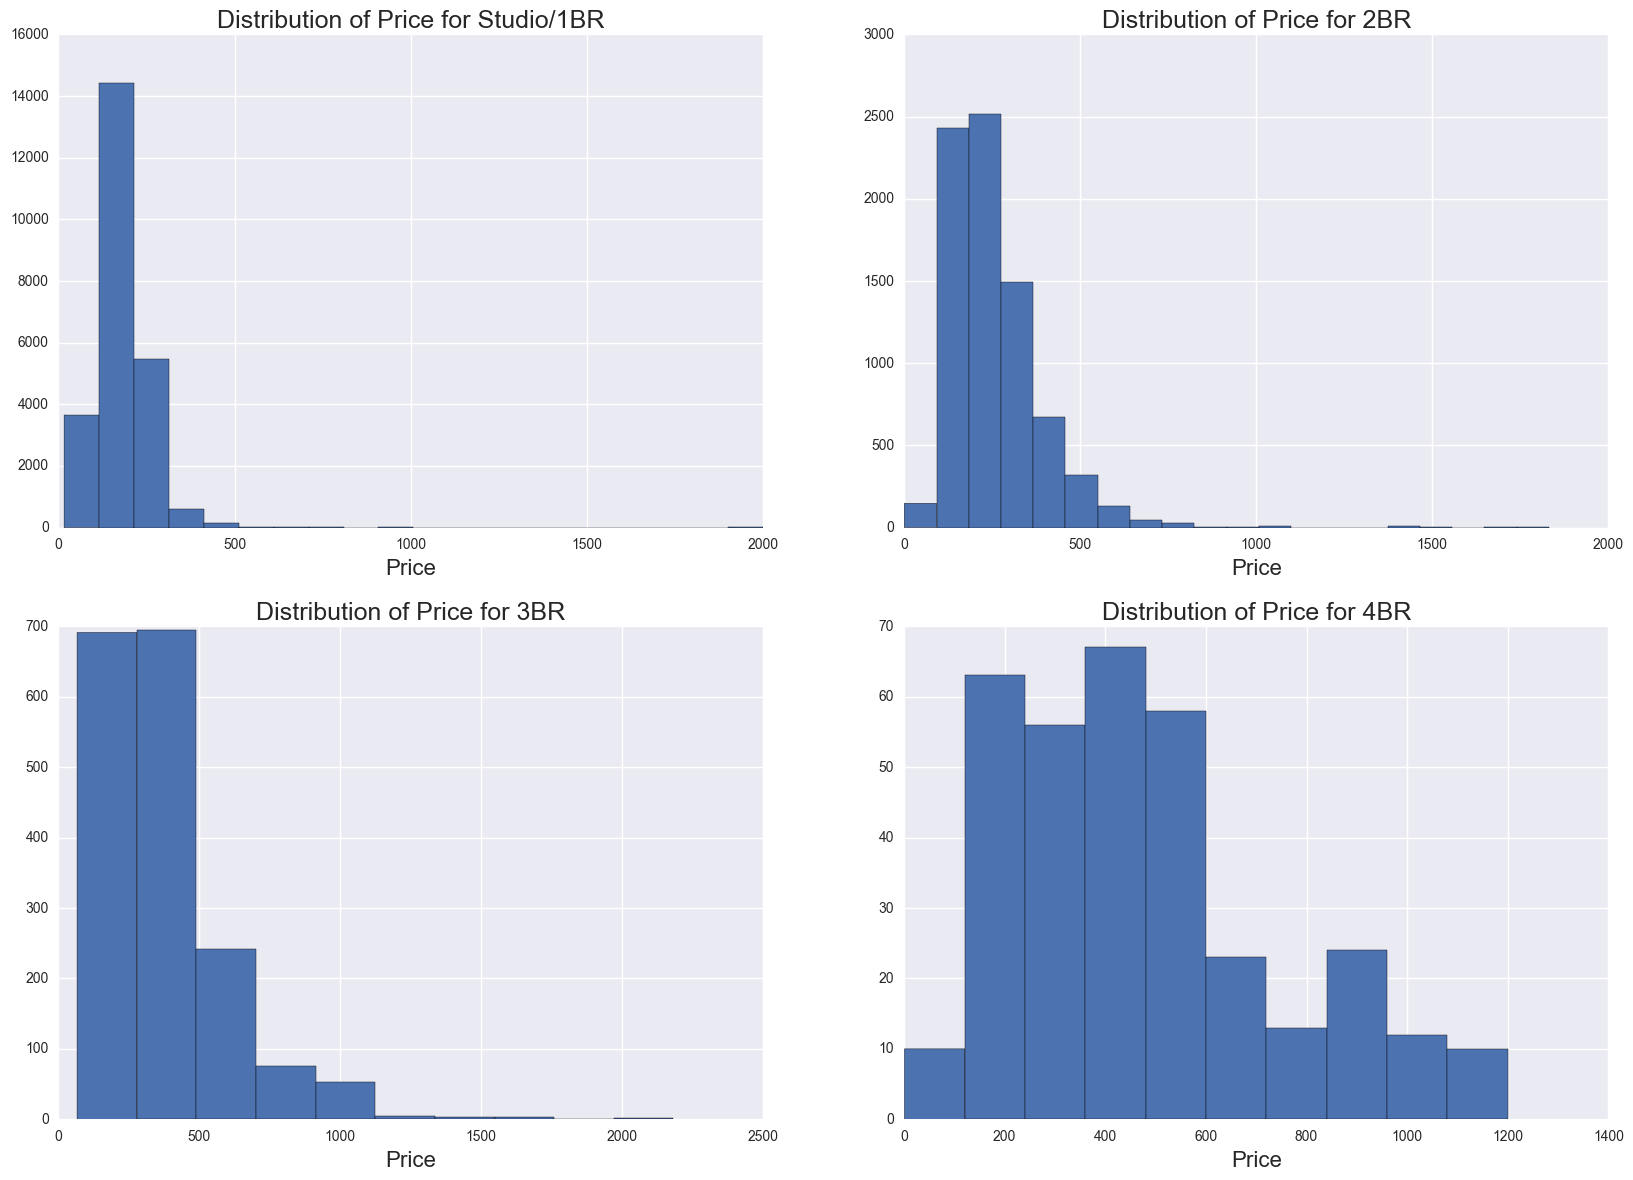

In [100]:
histograms(occ15_entire)

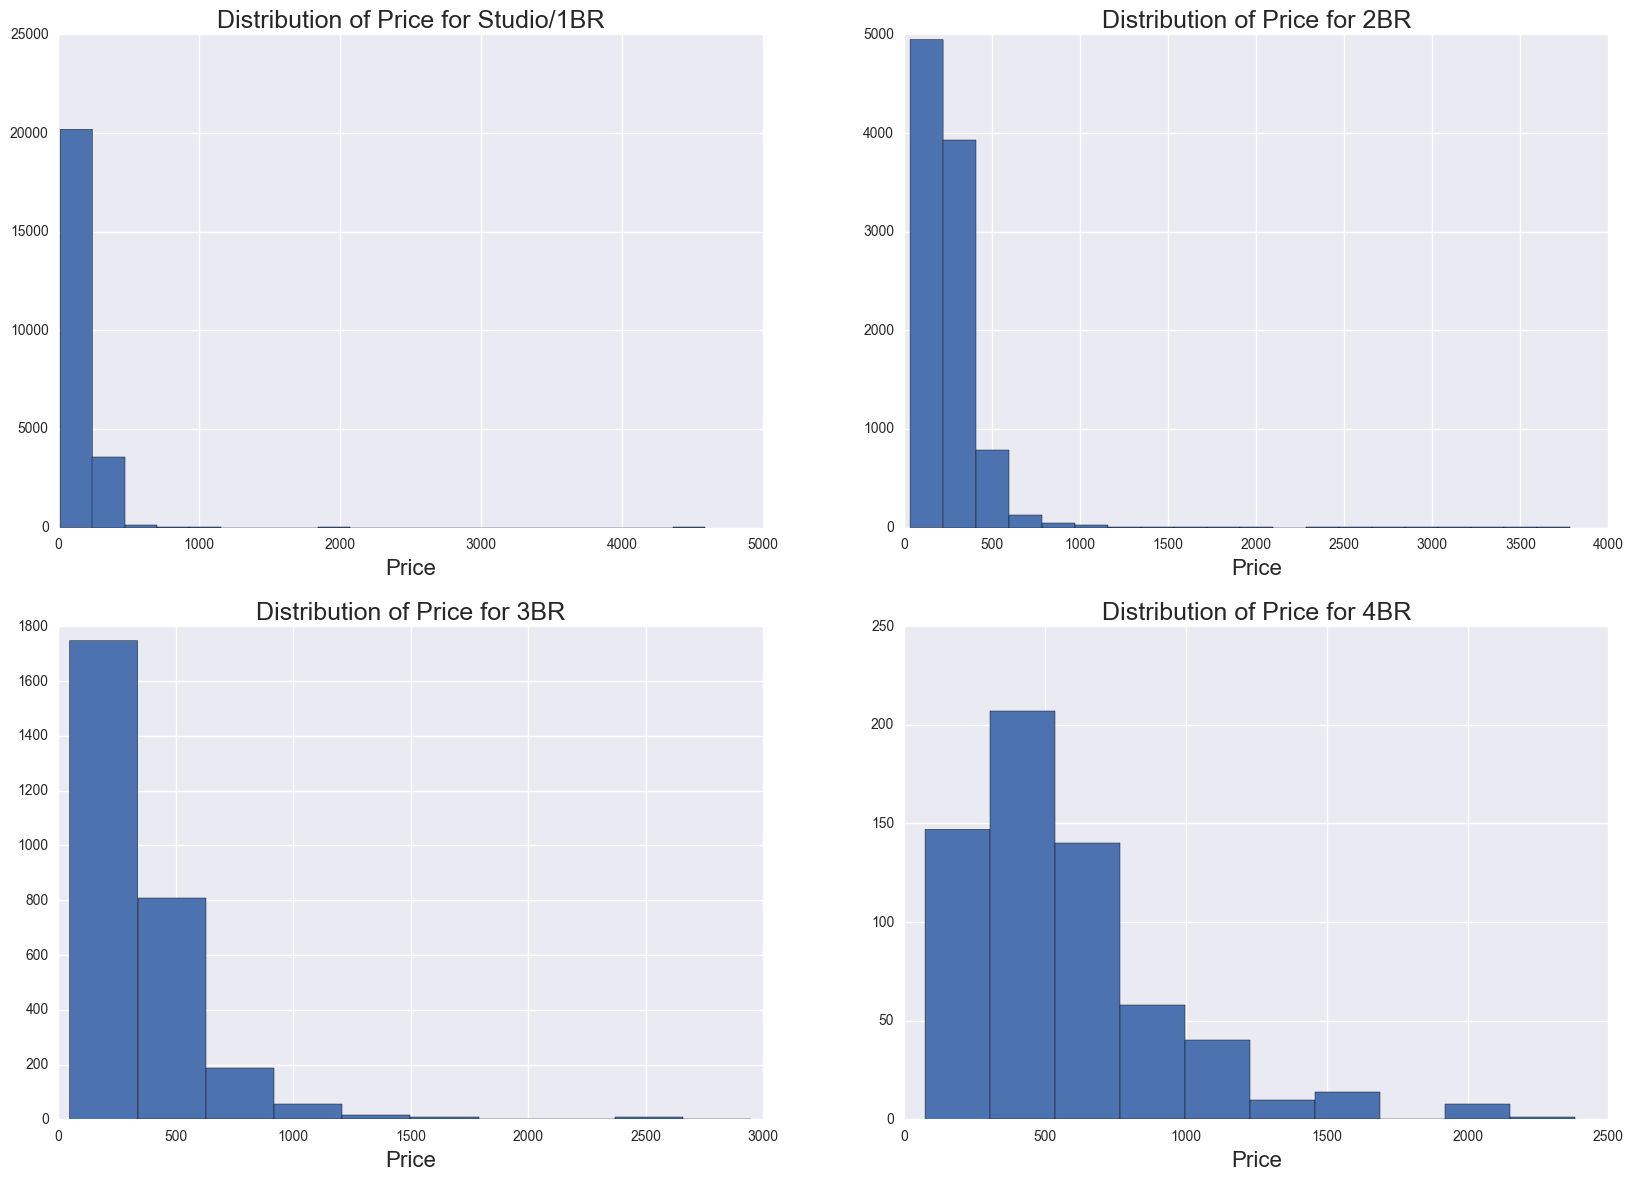

In [69]:
histograms(occ16_entire)

#### Setting Price Thresholds to remove outliers

In [85]:
def price_thresholds(df,onebr_lower,onebr_upper,twobr_lower,twobr_upper,threebr_lower,threebr_upper,fourbr_lower,fourbr_upper):
    
    df_studio = df[(df['bedrooms']==0) & (df['avg_price']>onebr_lower) & (df['avg_price']<onebr_upper) ]
    df_1br = df[(df['bedrooms']==1) & (df['avg_price']>onebr_lower) & (df['avg_price']<onebr_upper) ] 
    df_2br = df[(df['bedrooms']==2) & (df['avg_price']>twobr_lower) & (df['avg_price']<twobr_upper) ]
    df_3br = df[(df['bedrooms']==3) & (df['avg_price']>threebr_lower) & (df['avg_price']<threebr_upper) ]
    df_4br = df[(df['bedrooms']==4) & (df['avg_price']>fourbr_lower) & (df['avg_price']<fourbr_upper) ] 
    
    df_1br = df_1br.append(df_studio)
    df_1br_2br = df_1br.append(df_2br)
    df_3br_4br = df_3br.append(df_4br)
    data = df_1br_2br.append(df_3br_4br)
    data.reset_index(inplace = True,drop=True)
    data['revpar'] = (data['avg_price'] * data['occ%']/100).round(2)
    print 'Removing outliers, the dataframe shape is:',data.shape
    return data

In [87]:
data_2015 = price_thresholds(occ15_entire,50,350,85,600,85,800,100,1500)
data_2016 = price_thresholds(occ16_entire,50,350,85,600,85,800,100,1500)

Removing outliers, the dataframe shape is: (33207, 22)
Removing outliers, the dataframe shape is: (35384, 22)


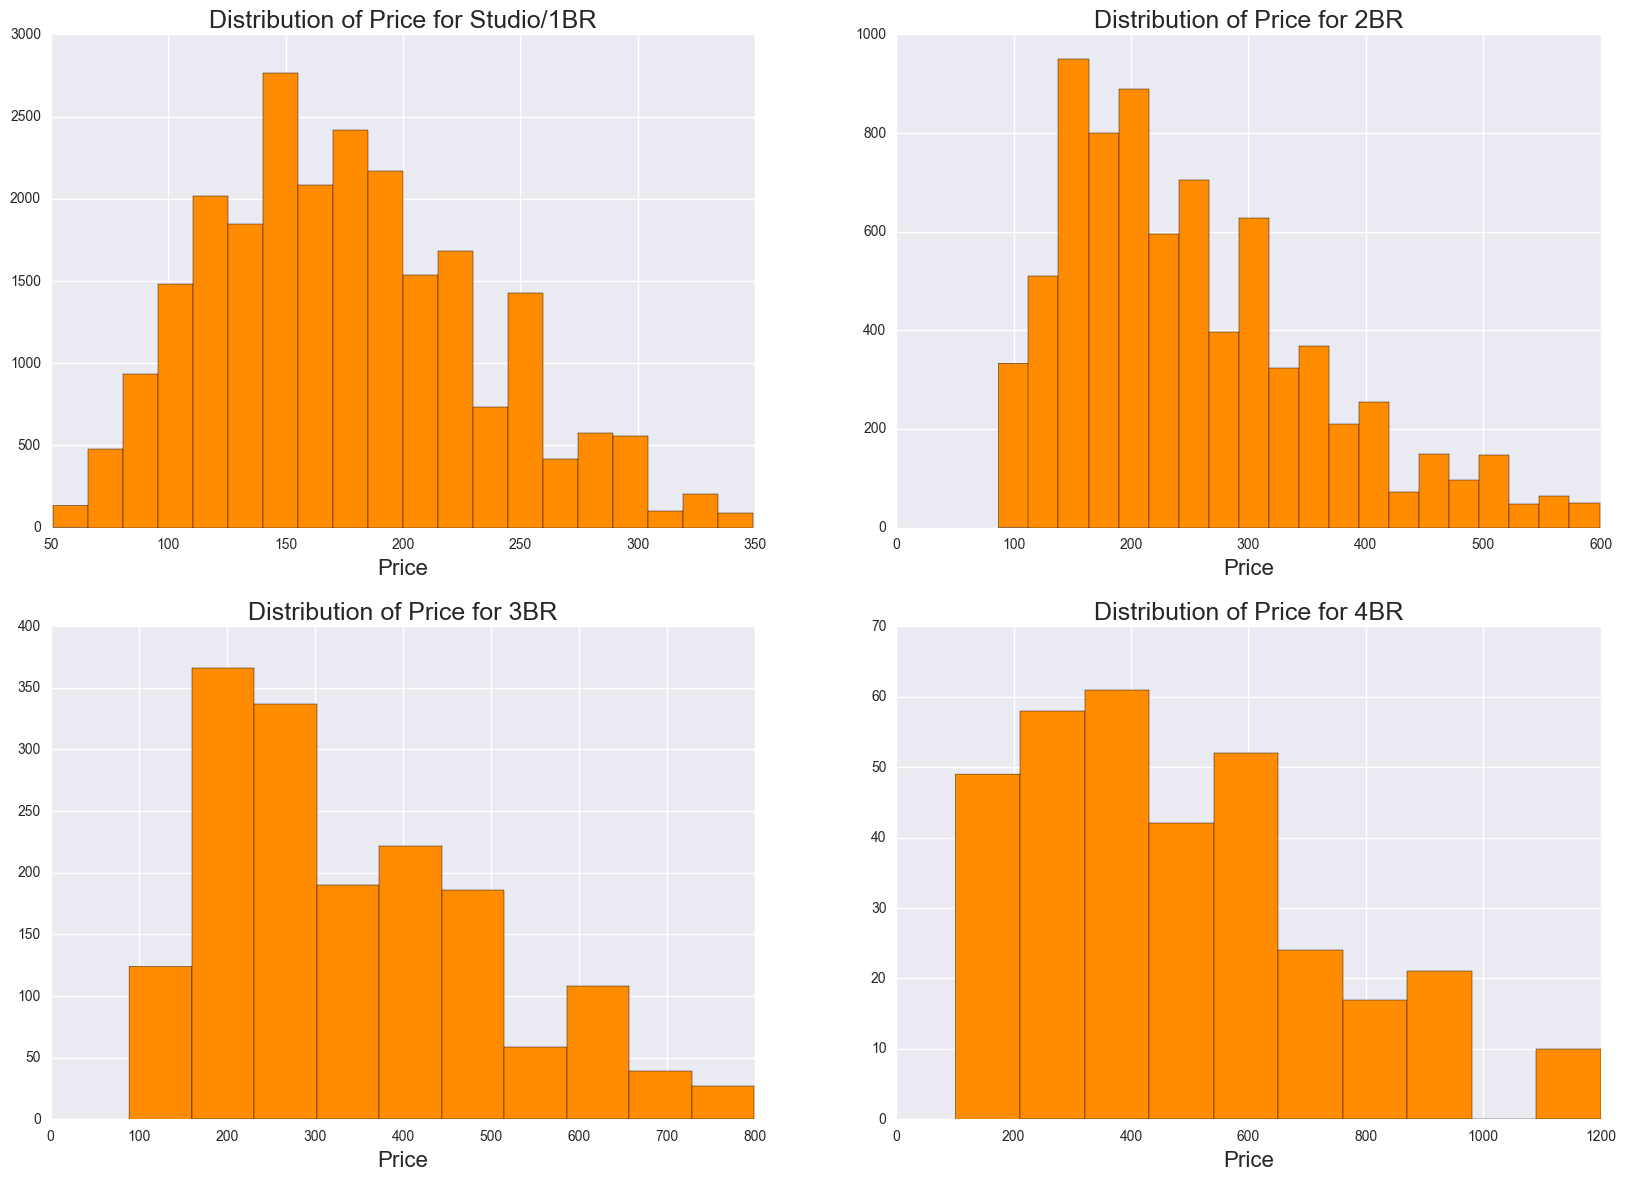

In [101]:
histograms(data_2015,'darkorange')

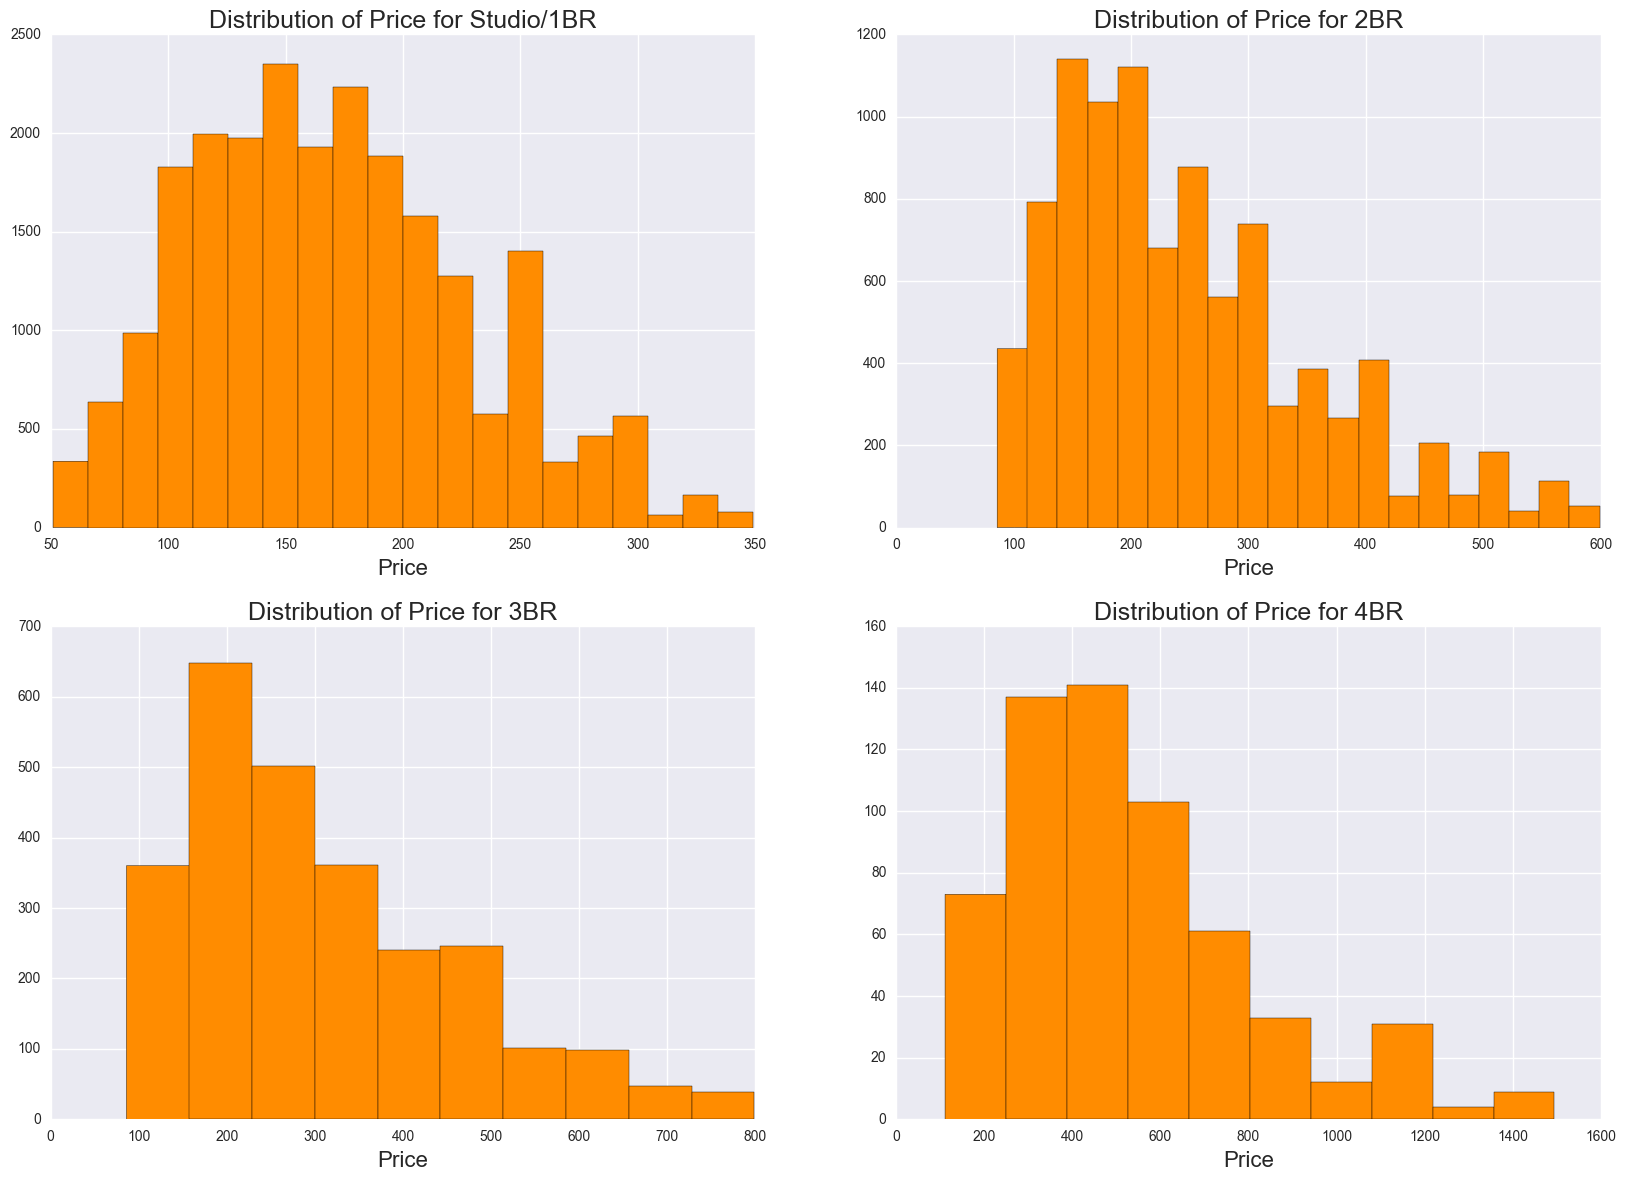

In [102]:
histograms(data_2016,'darkorange')

In [106]:
def trend_graphs(df):
    '''Creating groupby on neighborhood and finding average occupancy and price'''
    occ_by_nhood = df.groupby(['neighborhood','area','bedrooms','month'])['days_per_month','occupied','listing_id'].\
                            agg({'listing_id':len,'days_per_month':sum,'occupied':sum})
    occ_by_nhood.reset_index(inplace= True)
    occ_by_nhood['occ%'] = (100*(occ_by_nhood['occupied'] / occ_by_nhood['days_per_month'])).round(2)
    occ_by_nhood_price = data_2015.groupby(['neighborhood','area','bedrooms','month'])['avg_price'].\
            agg({'avg_price_mean':np.mean,'avg_price_median':np.median})
    occ_by_nhood_price.reset_index(inplace = True)
    #merging the occupancy by neighborhood and price
    nhood_metrics = pd.merge(occ_by_nhood,occ_by_nhood_price)
    nhood_metrics['avg_price_mean'] = nhood_metrics['avg_price_mean'].astype(int)
    nhood_metrics['avg_price_median'] = nhood_metrics['avg_price_median'].astype(int)
    nhood_metrics['revpar'] = (nhood_metrics['avg_price_median'] * nhood_metrics['occ%']/100).round(2)
    
    #plotting occupancy by month by bedroom
    plt.subplots(figsize=(15,7))
    sns.distplot(nhood_metrics[nhood_metrics['bedrooms']==4]['occ%'])
    sns.pointplot(data=nhood_metrics,x='month',y='occ%',hue='bedrooms')
    plt.title('Occupancy per Month by Bedroom',fontsize=18)
    plt.ylabel('Occupancy',fontsize=14)
    plt.xlabel('Month',fontsize = 14)
    plt.ylim(0,100)
    plt.show();
    
    #plotting price by month by bedroom
    plt.subplots(figsize=(15,7))
    sns.pointplot(data=nhood_metrics,x='month',y='avg_price_mean',hue='bedrooms')
    plt.title('Median Price per Month by Bedroom',fontsize=18)
    plt.ylabel('Median Price',fontsize=14)
    plt.xlabel('Month',fontsize = 14)
    plt.show();
    
    #plotting RevPAR (occupancy * ADR) by month by bedroom
    plt.subplots(figsize=(15,7))
    sns.pointplot(data=nhood_metrics,x='month',y='revpar',hue='bedrooms',estimator=np.mean)
    plt.title('Median RevPAR per Month by Bedroom',fontsize=18)
    plt.ylabel('Median RevPAR',fontsize=14)
    plt.xlabel('Month',fontsize = 14)
    plt.ylim(0,600)
    plt.show;
    return nhood_metrics

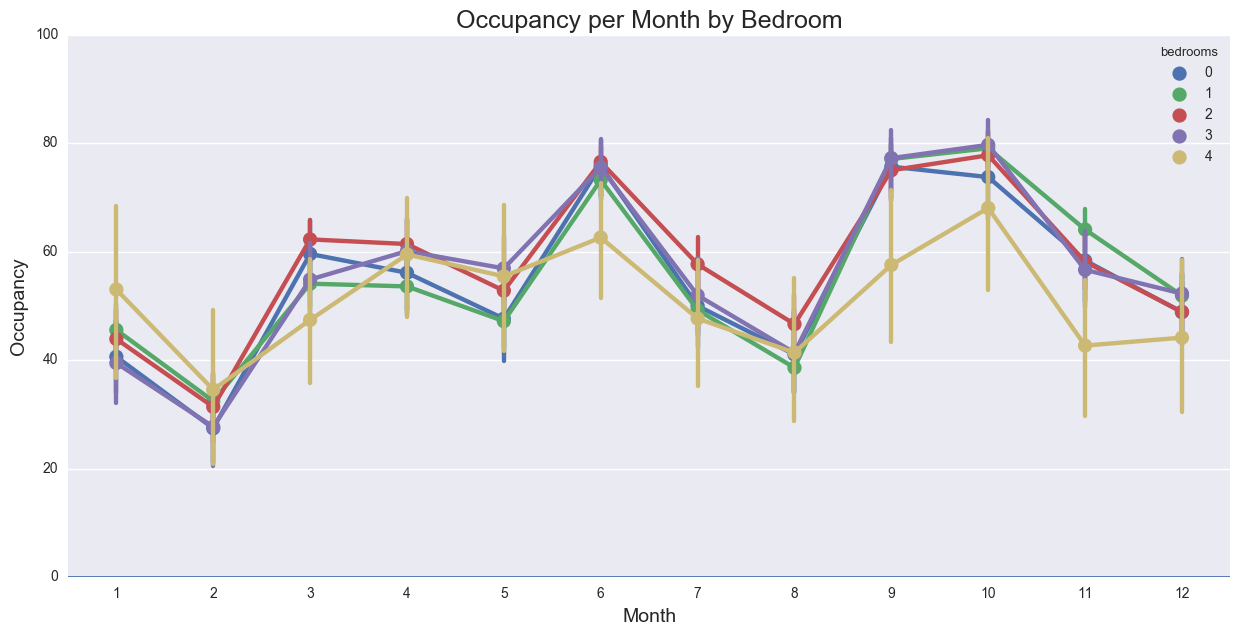

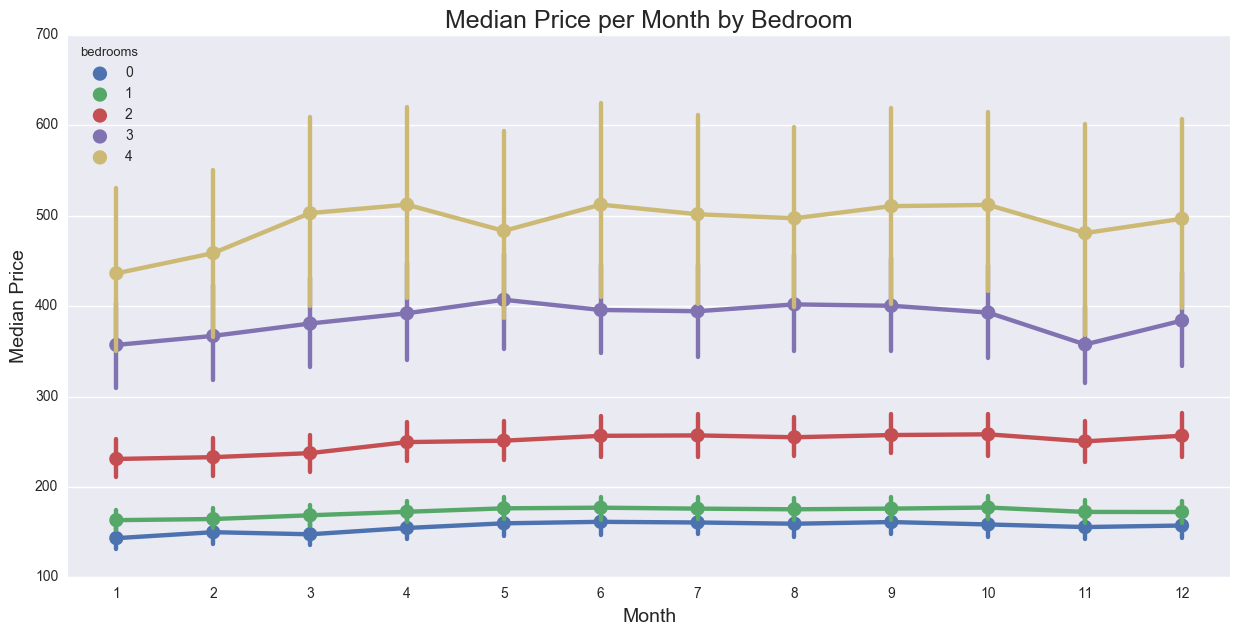

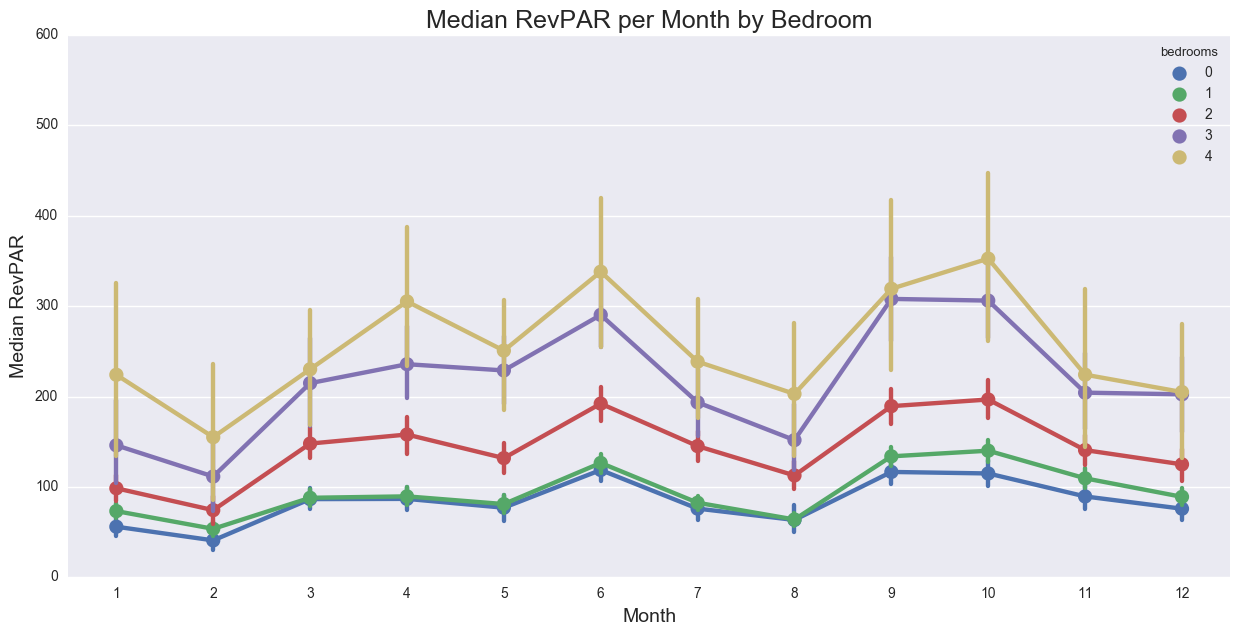

In [107]:
nhood_15 = trend_graphs(data_2015)

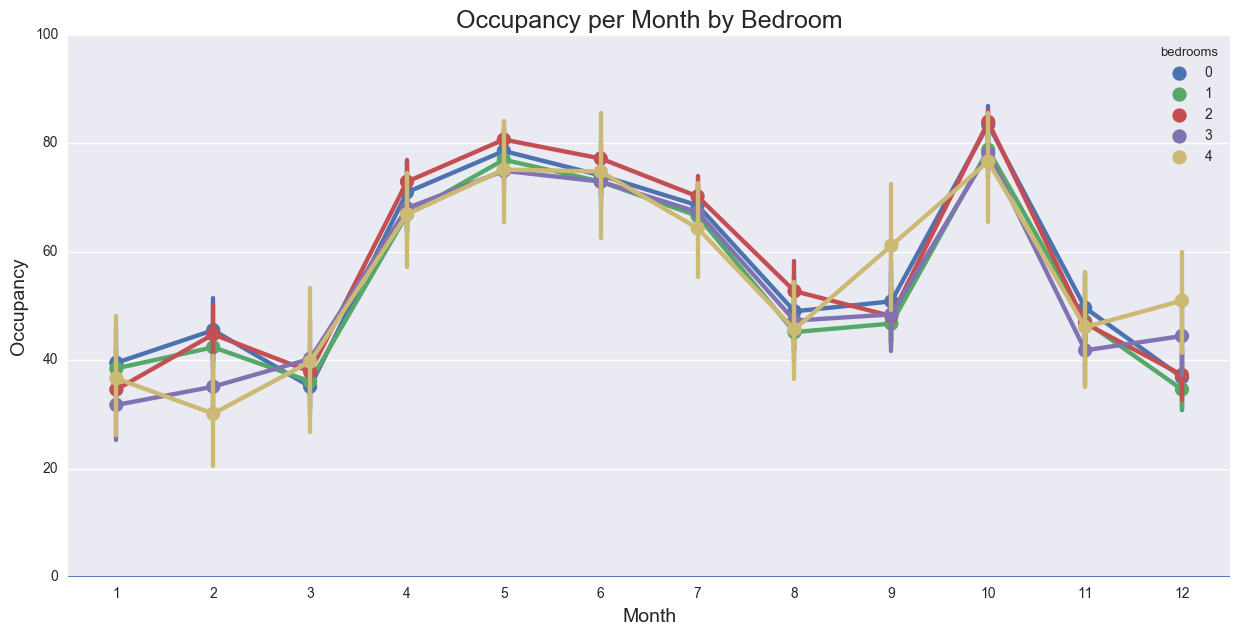

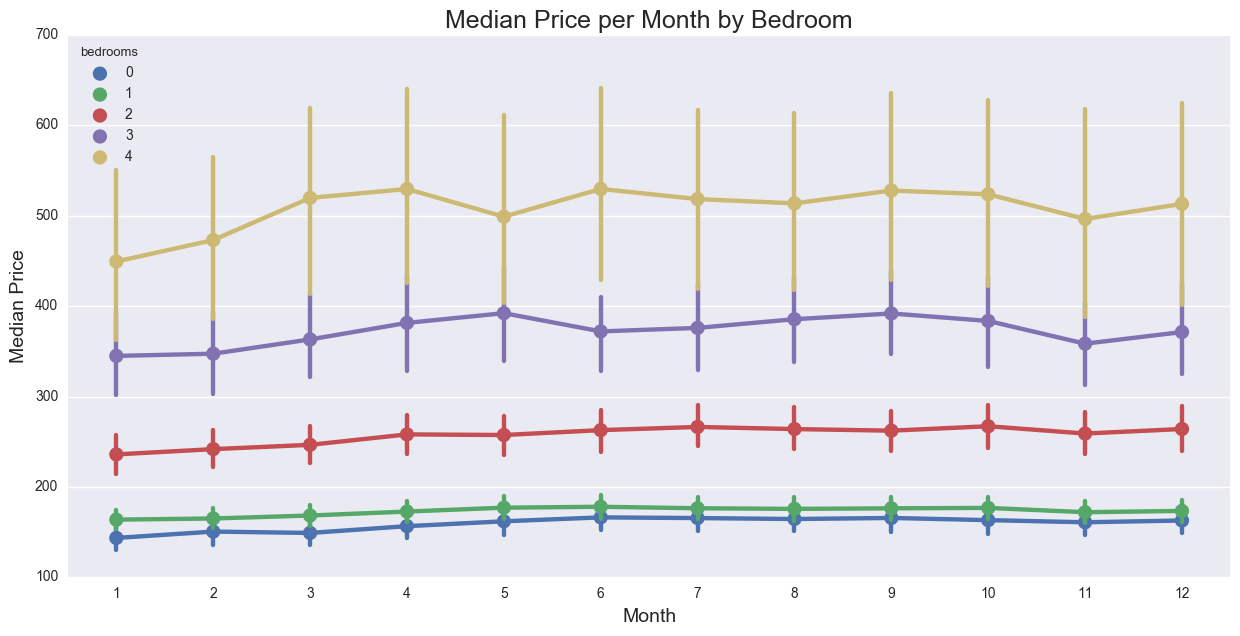

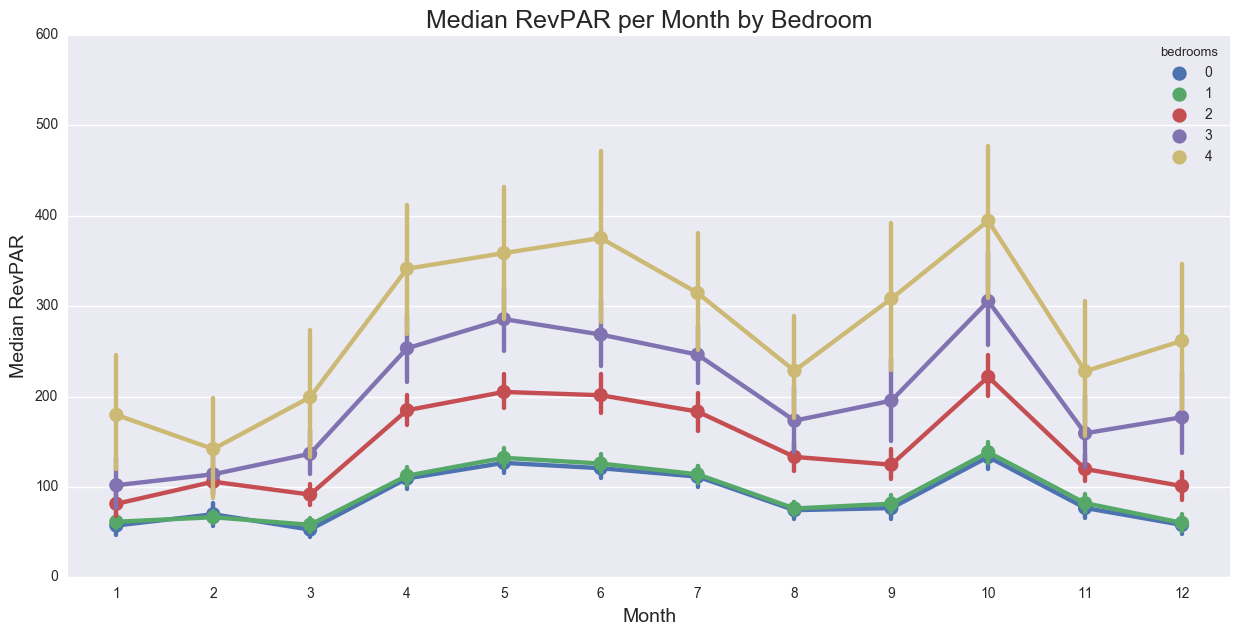

In [108]:
nhood_16 = trend_graphs(data_2016)